### NLP-Based Drift Detection Techniques

In [1]:
# Importing the necessary libaries

import nltk
import numpy as np
import pandas as pd
from deepchecks.nlp import TextData
from deepchecks.nlp.checks import PropertyDrift

from test_data import TEST_QUESTIONS

In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/kishoresampath/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Loading the training data

train_df = pd.read_csv("train_data.csv")
train_df = train_df.drop(columns=["context", "response"])
train_df.head()

,question
0,Were there prior instances of the Theory of Co...
1,Was the Theory of Computation course previousl...
2,What is the past history of the Theory of Comp...
3,List the professor teaching Building Extensibl...
4,What are the Engineering LLM-integrated Sys co...


#### 1. Deepchecks NLP Property Drift

In [4]:
train = TextData(raw_text=train_df["question"].tolist())
train.calculate_builtin_properties()

test = TextData(raw_text=TEST_QUESTIONS)
test.calculate_builtin_properties()

/home/kishoresampath/dev/nlp-data-drift-detection/env/lib/python3.10/site-packages/deepchecks/nlp/utils/text_properties.py:867: UserWarning:

Onnx models require the optimum[onnxruntime-gpu] library to be installed. Calculating using the default models.

100%|██████████| 9/9 [00:00<00:00, 82.29it/s]


In [5]:
check_result = PropertyDrift().run(train, test)
check_result

In [6]:
check_result.value

{'Subjectivity': {'Drift score': 0.271978021978022,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Sentiment': {'Drift score': 0.27618300067279655,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 '% Special Characters': {'Drift score': 0.26388888888888884,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Average Word Length': {'Drift score': 0.3032407407407407,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Average Words Per Sentence': {'Drift score': 0.2870370370370371,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 '% Punctuation': {'Drift score': 0.25462962962962965,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Reading Ease': {'Drift score': 0.13862413097106974,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Language': {'Drift score': 0.29578801831086066,
  'Method': "Cramer's V",
  'Importance': None},
 'Lexical Density': {'Drift score': 0.3472222222222222,
  'Method': 'Kolmogorov-Smirnov',
  'Importan

In [7]:
THRESHOLD = 0.25

has_drifted = False
drifts = {}

for check_type, check_results in check_result.value.items():
    drift_score = check_results["Drift score"]
    
    if drift_score >= THRESHOLD:
        has_drifted = True
        drifts[check_type] = check_results

In [8]:
training_questions = train_df["question"].tolist()

#### 2. Mean Eucldean Distance Based Drift

In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")

training_embeddings = model.encode(training_questions)

In [10]:
from scipy.spatial.distance import pdist, squareform, cdist

training_mean_dist_bw_points = np.mean(squareform(pdist(training_embeddings)))
training_mean_dist_bw_points

1.0716464809730586

In [11]:
test_embeddings = model.encode(TEST_QUESTIONS)

In [12]:
test_pts_dist = np.mean(cdist(training_embeddings, test_embeddings), axis=0)

In [13]:
test_drift_pts_idx = np.where(test_pts_dist >= training_mean_dist_bw_points)[0]
test_drift_pts_idx.shape

(130,)

In [14]:
proportion_of_test_pts_drifted = test_drift_pts_idx.shape[0] / test_embeddings.shape[0]
proportion_of_test_pts_drifted

0.9027777777777778

#### 3. Text Enbeddings Density Based Drift 

/home/kishoresampath/dev/nlp-data-drift-detection/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



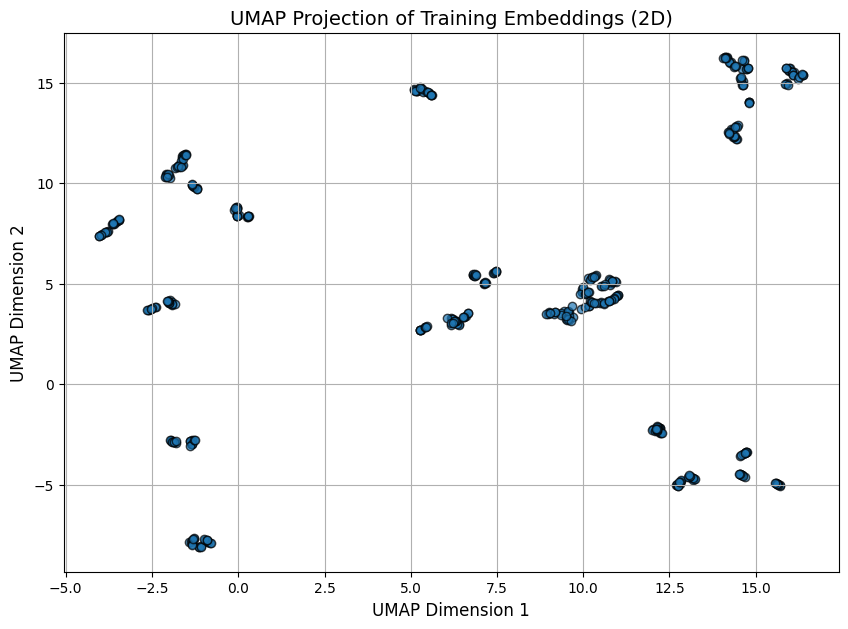

array([[ 9.553405 ,  3.5852091,  2.4299192],
       [ 9.536431 ,  3.583291 ,  2.3800147],
       [ 9.452707 ,  3.6472805,  2.3587894],
       ...,
       [10.59784  ,  4.0348907,  1.018381 ],
       [10.751739 ,  4.145252 ,  1.1696352],
       [10.752053 ,  4.14571  ,  1.1708931]], dtype=float32)

In [15]:
import umap
import matplotlib.pyplot as plt

# Reduce dimensions with UMAP
umap_reducer = umap.UMAP(n_components=3, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(training_embeddings)

# Prepare a scatter plot for visualization (projecting to 2D)
plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, edgecolors='k')
plt.title('UMAP Projection of Training Embeddings (2D)', fontsize=14)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True)
plt.show()

# Return the 3D reduced embeddings for further use if needed
reduced_embeddings


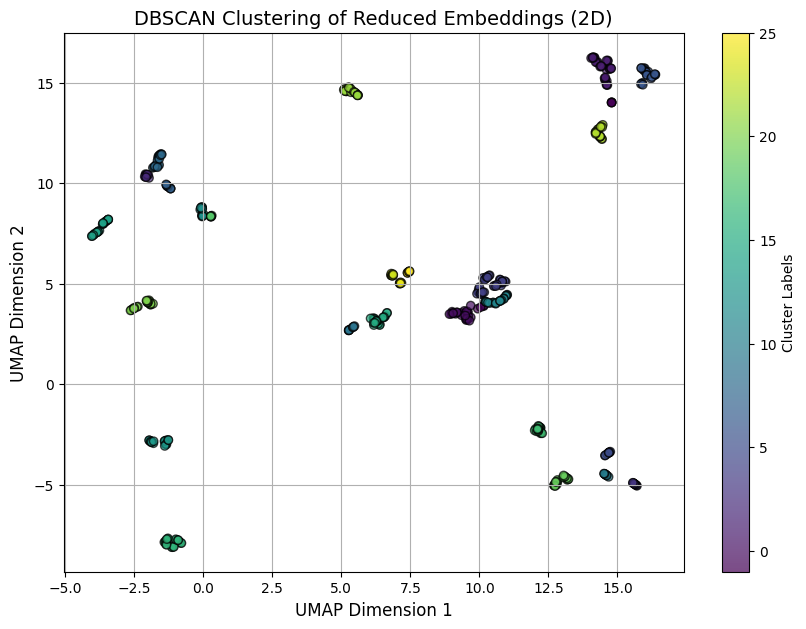

In [16]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN model to the reduced embeddings
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(reduced_embeddings)

# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.title('DBSCAN Clustering of Reduced Embeddings (2D)', fontsize=14)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True)
plt.colorbar(scatter, label='Cluster Labels')
plt.show()

/home/kishoresampath/dev/nlp-data-drift-detection/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



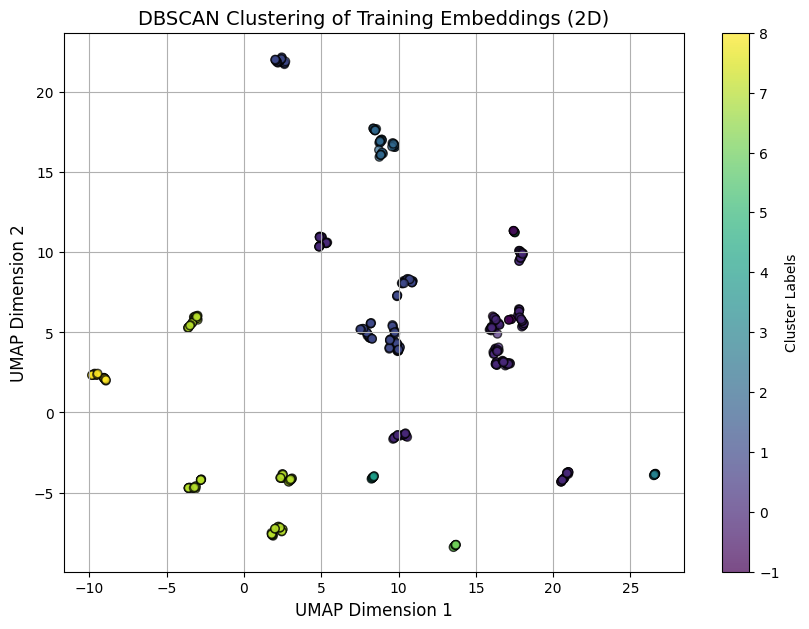

array([ 0,  0,  0,  1,  2,  3,  3,  3,  3,  3,  3,  2,  0, -1,  0,  4,  4,
        4,  0,  0,  0,  0,  0,  1,  1,  4,  0,  0,  0,  3,  3,  3,  3,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  5,  0,  5,  6,  6,  0,
        0,  2,  2,  2,  0,  0,  0,  0,  0,  0,  2,  1,  4,  4,  4,  4,  6,
        6,  6,  6,  6,  6,  6,  6,  0, -1, -1, -1, -1, -1,  0,  0,  0,  0,
        5,  0,  2,  1,  2,  2,  2,  2,  4,  4,  0,  0,  0,  0,  0,  0,  0,
        0,  7,  7,  7,  7,  1,  1,  1,  7,  7,  7,  7,  7,  7,  7,  7,  1,
        1,  1,  7,  7,  8,  8,  8,  8,  7,  7,  0,  0,  7,  7,  7,  7,  7,
        7,  5,  5,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  7,  7,  7,  7,
        8,  8,  0,  0,  7,  7,  7,  7,  1,  1,  7,  7,  5,  5,  7,  7,  0,
        0,  8,  8,  1,  1,  1,  7,  7,  7,  7,  7,  7,  1,  1,  1,  7,  7,
        0,  0,  1,  1,  1,  1,  0,  0,  7,  7,  1,  1,  1,  1,  1,  0,  0,
        0,  0,  8,  8,  7

In [17]:
from sklearn.cluster import DBSCAN
import umap
import matplotlib.pyplot as plt

# Train a DBSCAN model on the training embeddings
dbscan_model = DBSCAN(eps=0.7, min_samples=5)
training_labels = dbscan_model.fit_predict(training_embeddings)

# Perform dimensionality reduction with UMAP for visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_training_embeddings = umap_reducer.fit_transform(training_embeddings)

# Visualize the clustering results in 2D
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_training_embeddings[:, 0], reduced_training_embeddings[:, 1], 
                       c=training_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.title('DBSCAN Clustering of Training Embeddings (2D)', fontsize=14)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True)
plt.colorbar(scatter, label='Cluster Labels')
plt.show()

# Return the labels for further analysis if needed
training_labels

In [18]:
np.sum(training_labels == -1) / training_labels.shape[0]

0.018518518518518517

In [19]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
import numpy as np

# Fit DBSCAN on the training embeddings
dbscan_model = DBSCAN(eps=0.7, min_samples=5)
training_labels = dbscan_model.fit_predict(training_embeddings)

# Identify core points and their labels
core_mask = np.zeros_like(training_labels, dtype=bool)
core_mask[dbscan_model.core_sample_indices_] = True
core_points = training_embeddings[core_mask]
core_labels = training_labels[core_mask]

# Assign cluster labels to test points
test_distances = cdist(test_embeddings, core_points)  # Compute distances to core points
nearest_core_idx = np.argmin(test_distances, axis=1)  # Find the nearest core point for each test point
nearest_core_distances = test_distances[np.arange(test_embeddings.shape[0]), nearest_core_idx]

# Assign labels based on proximity to core points
test_labels = np.where(nearest_core_distances <= dbscan_model.eps, 
                       core_labels[nearest_core_idx], -1)  # Assign -1 if too far

# Visualize results
print("Training labels:", training_labels)
print("Predicted test labels:", test_labels)


Training labels: [ 0  0  0  1  2  3  3  3  3  3  3  2  0 -1  0  4  4  4  0  0  0  0  0  1
  1  4  0  0  0  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  5  0  5  6  6  0  0  2  2  2
  0  0  0  0  0  0  2  1  4  4  4  4  6  6  6  6  6  6  6  6  0 -1 -1 -1
 -1 -1  0  0  0  0  5  0  2  1  2  2  2  2  4  4  0  0  0  0  0  0  0  0
  7  7  7  7  1  1  1  7  7  7  7  7  7  7  7  1  1  1  7  7  8  8  8  8
  7  7  0  0  7  7  7  7  7  7  5  5  0  0  0  0  0  0  1  1  1  1  7  7
  7  7  8  8  0  0  7  7  7  7  1  1  7  7  5  5  7  7  0  0  8  8  1  1
  1  7  7  7  7  7  7  1  1  1  7  7  0  0  1  1  1  1  0  0  7  7  1  1
  1  1  1  0  0  0  0  8  8  7  7  0  0 -1 -1  1  1  7  7  7  7  7  7  8
  8  1  1  0  0  1  1  0  0  0  0  7  7  7  7  0  0  0  0  1  1  0  0  1
  1  0  0  1  1  1  1  1  0  0  7  7  0  0  0  0  8  8  0  0  1  1  1  1
  1  1  7  7  0  0  7  7  0  0  0  0  7  7  1  1  0  0  1  1  0  0  1  1
  7  7  0  0  1  1  8  8  0  0  0 

In [20]:
np.sum(test_labels == -1) / test_labels.shape[0]

0.3680555555555556

In [21]:
from question_drift_detector import QuestionDriftDetector

drift_detector = QuestionDriftDetector(
    training_questions, TEST_QUESTIONS
)

drift_detector.mean_euclidean_dist_drift()

2024-11-29 18:29:12 - QuestionDriftDetector - INFO - Initializing QuestionDriftDetector with 432 training questions and 144 testing questions.
2024-11-29 18:29:12 - QuestionDriftDetector - INFO - Loading SentenceTransformer model: all-mpnet-base-v2
2024-11-29 18:29:12 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2024-11-29 18:29:12 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-11-29 18:29:12 - QuestionDriftDetector - INFO - Encoding training and testing questions.


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2024-11-29 18:29:47 - QuestionDriftDetector - INFO - Generated training embeddings of shape: (432, 768)
2024-11-29 18:29:47 - QuestionDriftDetector - INFO - Generated testing embeddings of shape: (144, 768)
2024-11-29 18:29:47 - QuestionDriftDetector - INFO - Starting drift detection based on mean Euclidean distance with threshold 0.25.
2024-11-29 18:29:47 - QuestionDriftDetector - INFO - Mean Euclidean distance between training points: 1.0716
2024-11-29 18:29:47 - QuestionDriftDetector - INFO - Number of drifted test points: 130 out of 144
2024-11-29 18:29:47 - QuestionDriftDetector - INFO - Proportion of drifted test points: 0.9028
2024-11-29 18:29:47 - QuestionDriftDetector - WARNING - Drift detected. Proportion of drifted points exceeds the threshold.


True

In [22]:
drift_detector.text_properties_drift(visualize=True)

2024-11-29 18:29:47 - QuestionDriftDetector - INFO - Starting text properties drift detection with threshold 0.25.
2024-11-29 18:29:47 - QuestionDriftDetector - INFO - Downloading necessary NLTK resources.
/home/kishoresampath/dev/nlp-data-drift-detection/env/lib/python3.10/site-packages/deepchecks/nlp/utils/text_properties.py:867: UserWarning:

Onnx models require the optimum[onnxruntime-gpu] library to be installed. Calculating using the default models.

100%|██████████| 9/9 [00:00<00:00, 69.55it/s]
2024-11-29 18:29:51 - QuestionDriftDetector - INFO - Running PropertyDrift check using DeepChecks NLP.
2024-11-29 18:29:52 - QuestionDriftDetector - INFO - Saving PropertyDrift results as HTML.
2024-11-29 18:29:52 - QuestionDriftDetector - INFO - Property 'Subjectivity' drift score: 0.2720
2024-11-29 18:29:52 - QuestionDriftDetector - WARNING - Drift detected for property 'Subjectivity'.
2024-11-29 18:29:52 - QuestionDriftDetector - INFO - Text properties drift detection result: True


True

In [23]:
drift_detector.text_embeddings_density_based_drift()

2024-11-29 18:29:52 - QuestionDriftDetector - INFO - Starting density-based drift detection using DBSCAN.
2024-11-29 18:29:52 - QuestionDriftDetector - INFO - Assigned cluster labels to test points.
2024-11-29 18:29:52 - QuestionDriftDetector - INFO - Proportion of noise points in test data: 0.3681
2024-11-29 18:29:52 - QuestionDriftDetector - WARNING - Drift detected due to high proportion of noise points.


True